# Approximating Observed Microbiome Data with `microbiomeDASim`

An important goal of the Bioconductor package `microbiomeDASim` is the ability to closely approximate real data from longitudinal experiements where sequencing was performed. To demonstrate the ability we will approximate observed data from a longitudinal study on the human gut microbiome in gnotobiotic mice (Turnbaugh et. al., 2009 [doi.10.1126/scitranslmed.3000322](https://stm.sciencemag.org/content/1/6/6ra14)). This data file is available within the `metagenomeSeq` Bioconductor package.

As a first step we will load the necessary packages used during this analysis.

In [2]:
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")

#installing bioconductor pacakges specific packages from bioconductor
.list_of_conductor_packages <- c("metagenomeSeq")
lapply(.list_of_conductor_packages, function(x) if(!requireNamespace(x, quietly=TRUE)) BiocManager::install(x))
#installing cran packages
.list_of_cran_packages <- c("tidyverse", "ggplot2")
lapply(.list_of_cran_packages, function(x) if(!requireNamespace(x, quietly=TRUE)) install.packages(x))

#loading/installing all of the needed packages
sapply(c(.list_of_conductor_packages, .list_of_cran_packages),
       function(x) invisible(require(x, character.only = TRUE)))

#using the development version available on GitHub
devtools::install_github("williazo/microbiomeDASim")
require(microbiomeDASim)

[[1]]
NULL

[[1]]
NULL

[[2]]
NULL

metagenomeSeq     tidyverse       ggplot2 
         TRUE          TRUE          TRUE

Skipping install of 'microbiomeDASim' from a github remote, the SHA1 (14bce08b) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: microbiomeDASim



We next load in the mouse data. This dataset is stored as an MRexperiment object with assay data collected at the OTU level. The raw counts represent over 10,000 OTUs that were sequences from a total of 139 samples. These samples represent repeated measurements taken on 12 gnotobiotic mice. All mice were fed the same low-fat, plant polysaccharide–rich diet for the first 21 days of the study. At this point 6 of the mice were then switched to a  high-fat, high-sugar “Western” diet. The subseqeuent changes in the microbial community were then observed over a follow-up of roughly 60 days.

In [3]:
# loading in longitudinal microbiome data from Turnbaugh et. al 2009
data("mouseData")
mouseData

MRexperiment (storageMode: environment)
assayData: 10172 features, 139 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: PM1:20080107 PM1:20080108 ... PM9:20080303 (139 total)
  varLabels: mouseID date ... status (5 total)
  varMetadata: labelDescription
featureData
  featureNames: Prevotellaceae:1 Lachnospiraceae:1 ...
    Parabacteroides:956 (10172 total)
  fvarLabels: superkingdom phylum ... OTU (7 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

Many of the OTUs are low frequency obserations that do not match out multivariate normal distributional assumptions, especially given our limited sample size (n=12). Therefore, we restrict our analysis to genus level counts rather than OTU level counts, which reduces the feature size from 10,172 to 61.

In [4]:
#aggregating the counts to the genus level
genus_mouseData <- metagenomeSeq::aggTax(mouseData, lvl="genus")
genus_mouseData

MRexperiment (storageMode: environment)
assayData: 61 features, 139 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: PM1:20080107 PM1:20080108 ... PM9:20080303 (139 total)
  varLabels: mouseID date ... status (5 total)
  varMetadata: labelDescription
featureData
  featureNames: Acetanaerobacterium Acinetobacter ... Xylanibacter (61
    total)
  fvarLabels: superkingdom phylum ... genus (6 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

We further apply presence and depth filters, and then log normalize the counts to represent our simulated outcome of interest.

In [5]:
#additional count filters
genus_mouseData <- filterData(genus_mouseData, present = 10, depth = 1000)
genus_mouseData
g_lnorm_mat <- MRcounts(genus_mouseData, norm=TRUE, log=TRUE)

MRexperiment (storageMode: environment)
assayData: 35 features, 137 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: PM1:20080108 PM1:20080114 ... PM9:20080303 (137 total)
  varLabels: mouseID date ... status (5 total)
  varMetadata: labelDescription
featureData
  featureNames: Akkermansia Alistipes ... Turicibacter (35 total)
  fvarLabels: superkingdom phylum ... genus (6 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

Default value being used.



We next randomly select a genus to use as our reference. In this case we select *Sutterella*, and this row of the log normalized count matrix will be our outcome.

In [6]:
set.seed(012020)
ex_feature <- sample(seq_len(dim(g_lnorm_mat)[1]), 1)
row.names(g_lnorm_mat)[ex_feature] #Sutterella
y <- g_lnorm_mat[ex_feature, ]

[1] "Sutterella"

We then combine the observed outcome with phenotype data on the samples which includes their ID, time since study began

In [7]:
sim_feat <- data.frame(y, pData(genus_mouseData))
sim_feat <- sim_feat[order(sim_feat$mouseID, sim_feat$relativeTime), ]
names(sim_feat)

sim_id_split <- split(sim_feat, sim_feat$mouseID)
sim_df <- lapply(sim_id_split, function(x){
    x$diet <- ifelse(any(x$diet=="Western"), "Western", x$diet)
    return(x)
})
sim_df <- data.frame(do.call(rbind, sim_df))
sim_df$diet <- as.factor(sim_df$diet)

[1] "y"            "mouseID"      "date"         "diet"         "relativeTime"
[6] "status"

In [ ]:
with(sim_df, microbiomeDASim::ggplot_spaghetti(y, mouseID, relativeTime, group=diet))+
    xlab("Time")+
    ylab("Normalized Reads")+
    scale_color_discrete(name="Diet")+
    scale_linetype_discrete(name="Diet")+
    ggtitle(paste0("Genus: ", row.names(genus_mouseData[ex_feature, ])))+
    geom_vline(xintercept=21, col="black", lty=2)

In [ ]:
ss_est <- fitTimeSeries(obj=genus_mouseData, formula=abundance~time*class,
                        feature=ex_feature, class="diet", id="mouseID",
                        time="relativeTime", norm=TRUE, log=TRUE, random=~1|id,
                        B=1000)
ss_est$timeIntervals
ggplot(data=ss_est$fit, aes(x=timePoints, y=fit))+
    geom_line()+
    geom_line(col="red", lty=2, aes(y=fit+1.96*se))+
    geom_line(col="red", lty=2, aes(y=fit-1.96*se))+
    geom_hline(col="black", yintercept=0)+
    geom_vline(xintercept=21, col="black", lty=2)

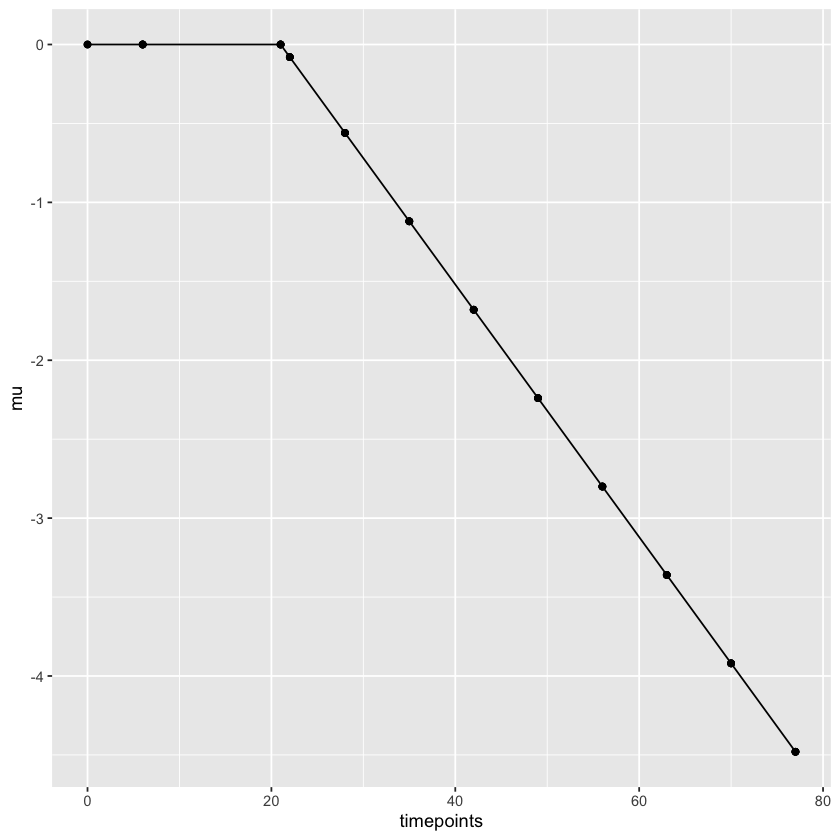

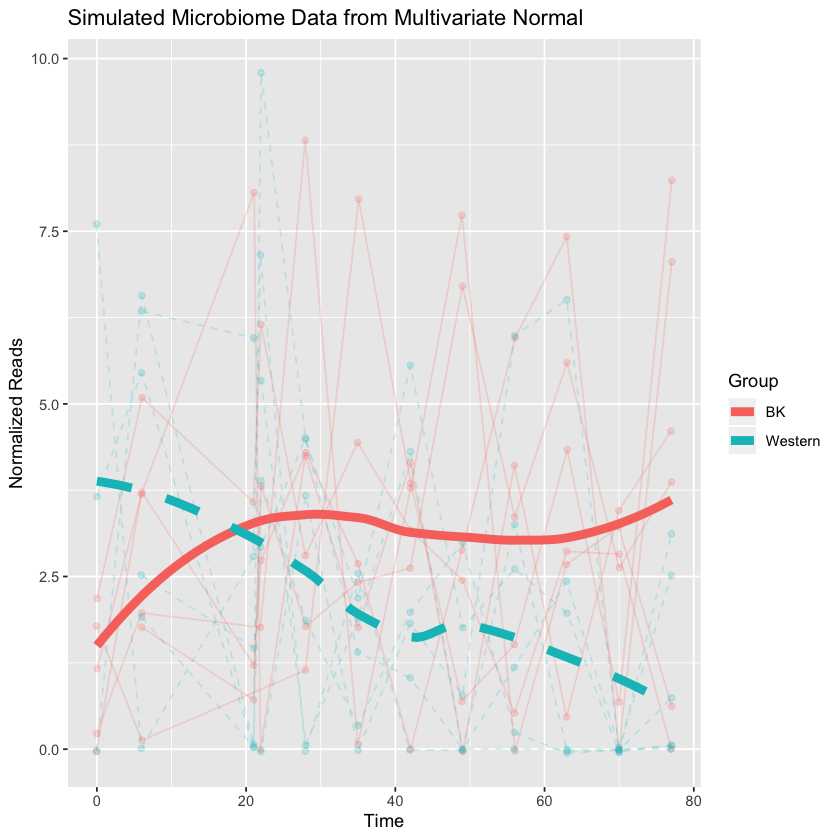

In [8]:
x_bar <- mean(sim_df$y)
s <- sd(sim_df$y)

sim_mouse <- mvrnorm_sim_obs(id=sim_df$mouseID, time=sim_df$relativeTime,
                group=sim_df$diet, ref="BK", control_mean=x_bar, sigma=s,
                rho=0.03, corr_str="ar1", func_form="L_up", IP=21,
                beta=-0.08, plot_trend=TRUE, dis_plot=TRUE)

In [ ]:
with(sim_mouse$df, microbiomeDASim::ggplot_spaghetti(Y, ID, time, group=group))+
    xlab("Time")+
    ylab("Simulated Normalized Reads")+
    scale_color_discrete(name="Diet")+
    scale_linetype_discrete(name="Diet")+
    ggtitle(paste0("Genus: ", row.names(genus_mouseData[ex_feature, ])))+
    geom_vline(xintercept=21, col="black", lty=2)